# Annotation of Il10-positive cells --- Clusters at 2 hours

# 0. Loading the libraries

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import joypy
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from adjustText import adjust_text
from pandas.api.types import CategoricalDtype

import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [2]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 108))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,35))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [3]:
sc.settings.verbosity = 3
plt.rcParams['figure.figsize']=(8,8) #rescale figures
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}
plt.rc('font', **font) #set the font

In [ ]:
# Set up constants
save_folder = "figures/"
objects_folder = "saved_objects/"
sc.settings.figdir = './'+save_folder
marker = "Il10" # to define Il10-positive cells

# 1. Il-10 expression

In [ ]:
# Load the pre-processed data

with open(objects_folder+'adata_preprocessed.pkl', 'rb') as inp:
    adata = pickle.load(inp)

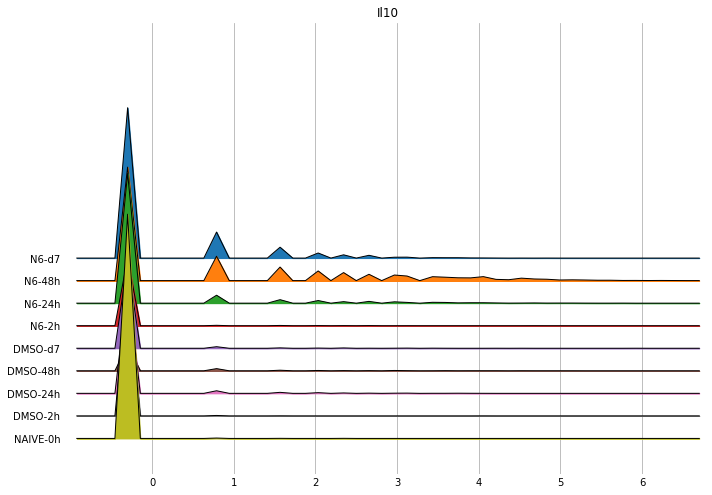

In [6]:
# Plot for each sample the distribution of marker expression across all cells

# Samples to show
conditions = ["N6-d7", "N6-48h", "N6-24h", "N6-2h", "DMSO-d7", "DMSO-48h", "DMSO-24h", "DMSO-2h", "NAIVE-0h"]
mycolors = plt.rcParams["axes.prop_cycle"].by_key()['color']

# Prepare a dataframe
data_ridge = pd.DataFrame()
data_ridge[marker] = np.array(adata.X[:, adata.var.index == marker])[:,0]
data_ridge['condi'] = np.array(adata.obs['sample2'])
data_ridge['condi'] = pd.Categorical(data_ridge['condi'], 
                      categories=conditions,
                      ordered=True)

# Create and save the joyplot
fig, axes = joypy.joyplot(data_ridge, column=marker, by="condi", 
                            kind="counts", bins=50, overlap=5, x_range=[-1,max(data_ridge[marker])],
                            grid="x", legend=False, figsize=(10,7), linewidth=1,
                            color=mycolors, title = marker)
fig.savefig(save_folder+"ridge_"+marker+".png")

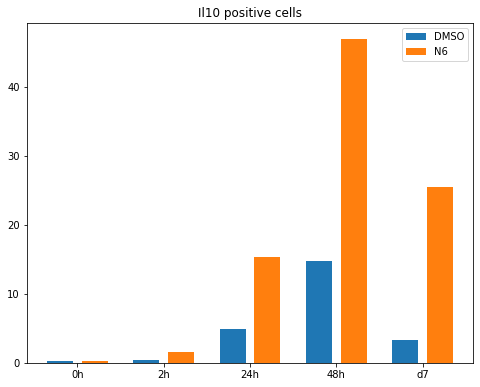

In [7]:
# Represent for each sample the proportion of marker-positive cells

plt.rcParams['figure.figsize']=(8,8) #rescale figures
plt.title(marker+' positive cells')


marker_data = pd.DataFrame()
conditions1 = ["NAIVE-0h", "DMSO-2h", "DMSO-24h", "DMSO-48h", "DMSO-d7"]
marker_data["x"] = conditions1
marker_data["y"] = [sum(data_ridge[data_ridge['condi'] == cond][marker] > 0) / len(data_ridge[data_ridge['condi'] == cond][marker]) for cond in conditions1]
marker_data["y"] = marker_data["y"]*100

pos = (0,10,20,30,40)
plt.bar(pos, marker_data["y"], width = 3, label='DMSO')

marker_data = pd.DataFrame()
conditions2 = ["NAIVE-0h", "N6-2h", "N6-24h", "N6-48h", "N6-d7"]
marker_data["x"] = conditions2
marker_data["y"] = [sum(data_ridge[data_ridge['condi'] == cond][marker] > 0) / len(data_ridge[data_ridge['condi'] == cond][marker]) for cond in conditions2]
marker_data["y"] = marker_data["y"]*100

pos = (4,14,24,34,44)
plt.bar(pos, marker_data["y"], width = 3, label='N6')

posx = (2,12,22,32,42)
plt.xticks(posx, ["0h", "2h", "24h", "48h", "d7"])
plt.subplots_adjust(bottom=0.4, top=0.99)
plt.legend()
plt.grid(visible=False)

plt.savefig(save_folder+marker+"_positive_cells.png")
plt.show()


In [8]:
#Define a variable that stores marker positivity
adata.obs[marker+'_positive'] = [marker+'+' if val>0 else marker+'-' for val in data_ridge[marker]]

adata.obs[marker+'_low'] = ['Low' if 0<val<1 else 'Not' for val in data_ridge[marker]]
adata.obs[marker+'_high'] = ['High' if val>3 else 'Not' for val in data_ridge[marker]]
adata.obs[marker+'_highlow'] = (adata.obs[marker+'_high']=='High') | (adata.obs[marker+'_low']=='Low')

# Represent marker-positive cells on the UMAP
s = 20
sc.pl.umap(adata, color=[marker+'_positive', marker+'_low', marker+'_high'], size = s, save=marker+'pos_cells.png')

computing density on 'umap'
--> added
    'umap_density_Il10_positive', densities (adata.obs)
    'umap_density_Il10_positive_params', parameter (adata.uns)
computing density on 'umap'
--> added
    'umap_density_Il10_high', densities (adata.obs)
    'umap_density_Il10_high_params', parameter (adata.uns)


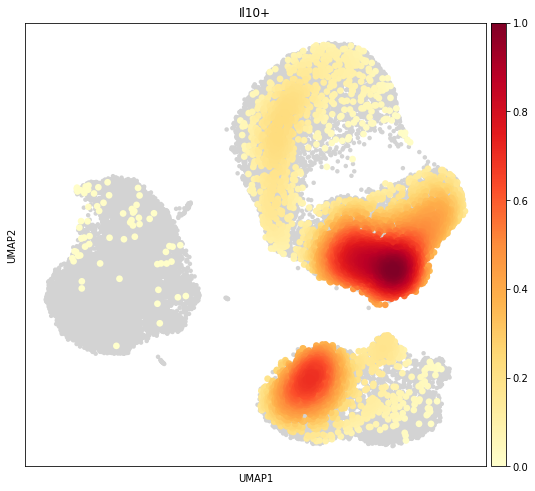

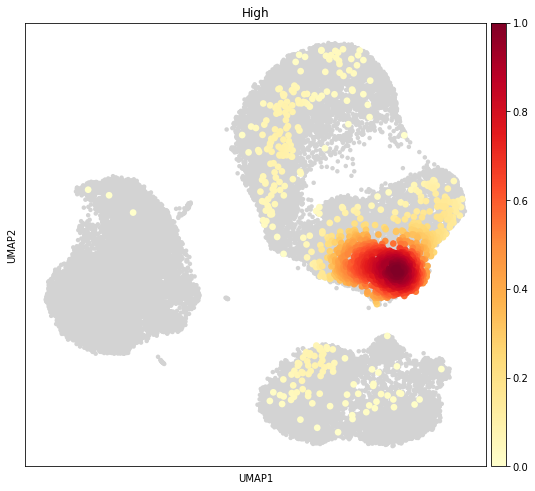

In [10]:
#Compute density on UMAP
sc.tl.embedding_density(adata, basis='umap', groupby=marker+'_positive')
sc.tl.embedding_density(adata, basis='umap', groupby=marker+'_high')

sc.pl.embedding_density(adata, basis='umap', key='umap_density_'+marker+'_positive', group=marker+'+', save=marker+"pos_cells_post.png")
sc.pl.embedding_density(adata, basis='umap', key='umap_density_'+marker+'_high', group='High', save=marker+"hi_cells_post.png")

In [11]:
save_object(adata, objects_folder+'adata_il10.pkl')

# 2. PCA to compare Il10+ and Il10- cells

In [12]:
# Subset to N6 at 24h, 48h, or d7
filt = (adata.obs.cond == "N6") & (adata.obs.tp != "2h")
bulkadata = adata[filt].copy()
bulkadata.X = adata[filt].raw.X

# Create a grouping variable
adata_tmp = adata[filt]
newobs = []
for i in range(len(adata_tmp.obs)):
    n = str(adata_tmp.obs.loc[adata_tmp.obs.index[i], 'tp']) +"_"+ str(adata_tmp.obs.loc[adata_tmp.obs.index[i], 'Il10_positive'])
    newobs.append(n)
bulkadata.obs['tp_il10'] = newobs

# Make a bulk average
bulk = pd.DataFrame(columns=set(bulkadata.obs['tp_il10']))
for samp in set(bulkadata.obs['tp_il10']):
    bulk[samp] = np.mean(bulkadata.X[bulkadata.obs['tp_il10']==samp,:], axis=0)
samp = bulk.columns
bulk = bulk.T

In [14]:
# Standardizing the features
bulk = StandardScaler().fit_transform(bulk)

# Compute PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(bulk)
principalDf = pd.DataFrame(data = principalComponents)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


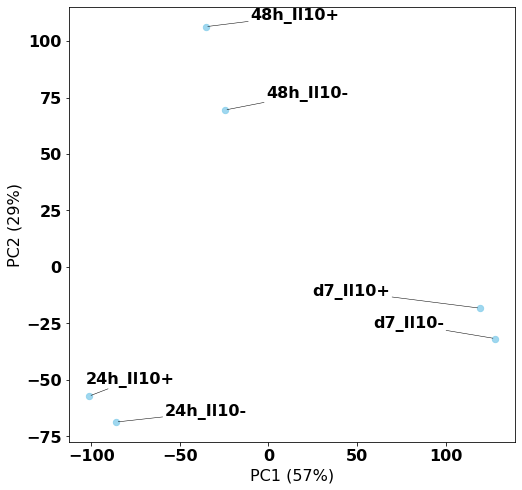

In [18]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)

# Final dataframe to plot
names = pd.Series(samp)
finalDf = pd.concat([principalDf, pd.Series(samp)], axis = 1)
pc1 = "PC1 ("+str(round(pca.explained_variance_ratio_[0]*100))+"%)"
pc2 = "PC2 ("+str(round(pca.explained_variance_ratio_[1]*100))+"%)"
finalDf.columns = [pc1, pc2, "samp"]

# Basic PCA plot
sb.regplot(data=finalDf, x=pc1, y=pc2, fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':40})

# Adjust text
texts = []
for x, y, s in zip(finalDf[pc1], finalDf[pc2], finalDf.samp):
    texts.append(plt.text(x, y, s))
adjust_text(texts, force_points=0.2, force_text=0.5,
            expand_points=(2, 2), expand_text=(1, 2),
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

plt.savefig(save_folder+"PCA_bulk_il10.png", bbox_inches = 'tight')
plt.show()

# 3. Clustering at 2 hours

In [6]:
with open(objects_folder+'adata_il10.pkl', 'rb') as inp:
    adata = pickle.load(inp)

# Subset to the cells of 2 hours
adata_2h = adata[adata.obs['tp'] == "2h"].copy()

# Perform an unsupervised clustering
sc.tl.leiden(adata_2h, resolution=0.4, random_state = 0) #0.4
idx = adata_2h.obs['leiden'].value_counts()[adata_2h.obs['leiden'].value_counts() > 20].index.tolist()
view = adata_2h[(adata_2h.obs['leiden'].isin(idx)) & (adata_2h.obsm['X_umap'][:,0]<4)]

/tmp/ipykernel_7068/1814800289.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  view.obs["color_Myc"] = np.log1p(np.array(view.raw.X[:, view.var_names == "Myc"]))
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


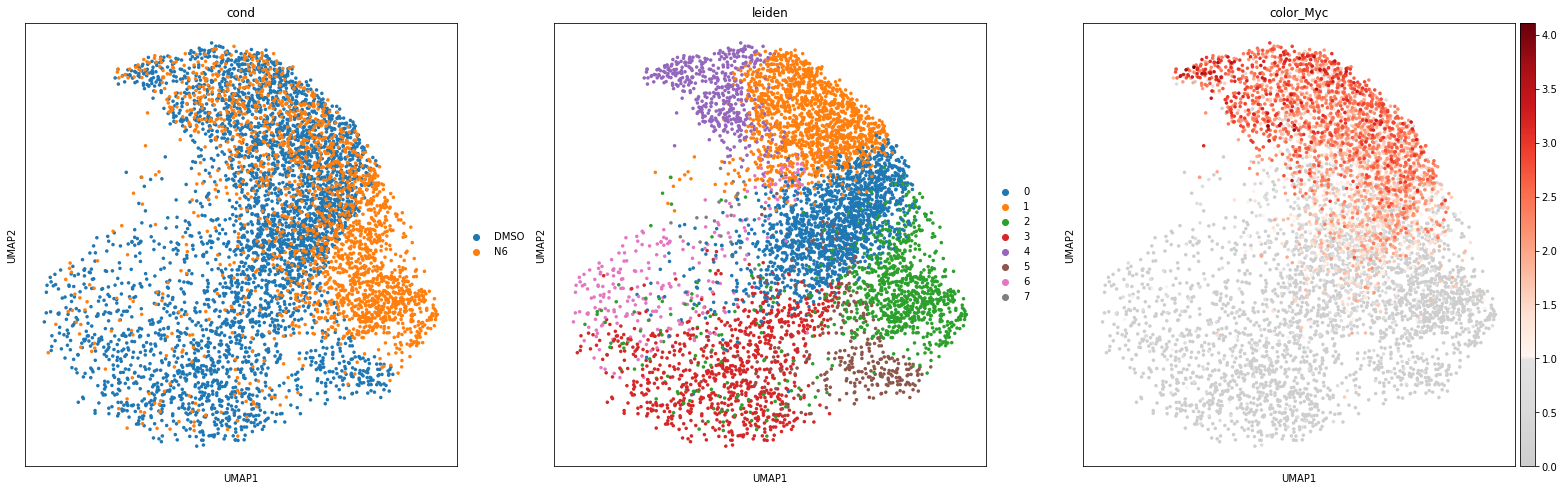

In [9]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}
plt.rc('font', **font) #reset font

view.obs["color_Myc"] = np.log1p(np.array(view.raw.X[:, view.var_names == "Myc"]))
sc.pl.umap(view, cmap=mymap, color = ['cond', 'leiden', 'color_Myc'], size = 50)

In [10]:
# Merge and rename clusters

obs_save = view.obs
dictio = {
    "0": 'N6-independent_2h', 
    "1": 'N6-independent_2h', 
    "2": 'N6-dependent_2h', 
    "3": 'Naïve-like_2h', 
    "4": 'N6-independent_2h',
    "5": 'Naïve-like_2h',
    "6": 'Naïve-like_2h',
    "7": 'Naïve-like_2h'
    }
cat_type = CategoricalDtype(categories=
    ['Naïve-like_2h', 'N6-dependent_2h', 'N6-independent_2h']
    ,ordered=True)
new_obs = obs_save['leiden'].map(dictio).astype(cat_type)
view.obs['clusters'] = new_obs

sc.pl.umap(view[view.obsm["X_umap"][:,0]<3], color = ['cond', 'clusters'], size = 70, save = "_2h_clustering.pdf", add_outline = False,
            palette = {
            "N6-independent_2h" : "slateblue", 
            "N6" : "tab:orange", 
            "N6-dependent_2h" : "gold", 
            "DMSO" : "tab:green", 
            "Naïve-like_2h" : "lawngreen"})

In [16]:
# Find cluster characteristic markers

view.X = view.raw.X
sc.pp.log1p(view)
sc.tl.rank_genes_groups(view, use_raw = False, groupby='clusters')
sc.pl.rank_genes_groups(view, fontsize = 20, n_genes=25, ncols=1, groups = ['N6-dependent_2h'])

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


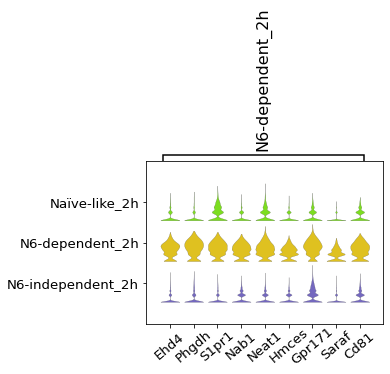

In [18]:
# Represent top marker genes on a violin plot

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

sv = sc.pl.rank_genes_groups_stacked_violin(view, fontsize = 20, n_genes=9, ncols=1, groups = ['N6-dependent_2h'],
        swap_axes=False, dendrogram=False, figsize=(6, 3), width=0.8, row_palette=['lawngreen', 'gold', 'slateblue'], return_fig=True)

plt.setp(sv.get_axes()['mainplot_ax'].xaxis.get_majorticklabels(), rotation=40, va="center", position=(0,-0.09))
plt.savefig(save_folder+"violin_n6-2h.png", bbox_inches='tight', dpi = 1000)

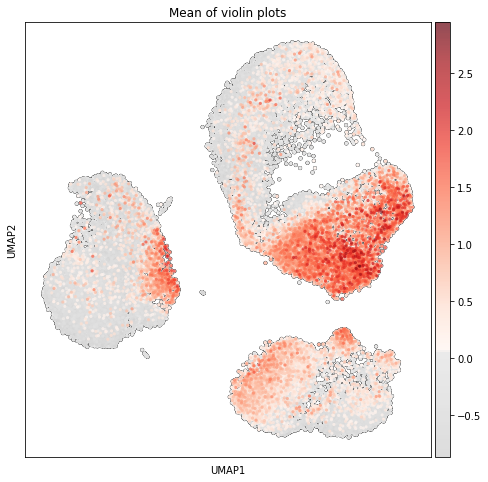

In [19]:
# Overlay the UMAP with the average expression of the marker genes

font = {'family' : 'normal', 'weight' : 'normal', 'size' : 10}
plt.rc('font', **font)

list_markers = ["Ehd4", "Phgdh", "S1pr1", "Nab1", "Hmces", "Cd81", "Saraf", "Neat1", "Gpr171"]
df = pd.DataFrame(columns=list_markers, index=adata.obs.index)
for mark in list_markers:
    df[mark] = adata.X[:, adata.var['gene_name'] == mark]
adata.obs["tm"] = df.mean(axis=1)

sc.pl.umap(adata, cmap = mymap, color = "tm", size = 40, add_outline = True, outline_width = [0.1, 0.05], title = "Mean of violin plots",
        ncols = 2, save = "_N6resp.png")

In [ ]:
# Save the cluster annotation for later
adata.obs['clusters_2h'] = view.obs['clusters']
save_object(adata, objects_folder+'adata_annotated.pkl')